In [1]:
import sys
import os
import matplotlib.pyplot as plt

# Add the path to utils.py
sys.path.append(r"C:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
sys.path.append(r"C:\Document\Serieux\Travail\python_work\cEBNM_torch\py\ebnm_solver")
sys.path.append(r"C:\Document\Serieux\Travail\python_work\cEBNM_torch\py\numerical_routine")
from distribution_operation import *
from utils import *
from numerical_routine import *
from posterior_computation import *
from ash import *
from utils_mix import *

In [2]:
import numpy as np
import sys
import os
sys.path.append(r"c:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
from distribution_operation import *
from utils import *
from numerical_routine import *
from posterior_computation import *
from utils_mix import *

class ash_object:
    def __init__(self, post_mean, post_mean2, post_sd, scale, pi, prior, log_lik=0,#log_lik2 =0,
                 mode=0):
        self.post_mean = post_mean
        self.post_mean2 = post_mean2
        self.post_sd = post_sd
        self.scale= scale
        self.pi =pi 
        self.prior= prior
        self.log_lik = log_lik
       # self.log_lik2= log_lik2 
        self.mode =  mode


def ash ( betahat,sebetahat, prior = "norm", mult=np.sqrt(2),penalty=10,verbose= True,threshold_loglikelihood =  -300, mode=0):
    
     
    if prior== "norm":
       
        scale=autoselect_scales_mix_norm(betahat  = betahat,
                                         sebetahat= sebetahat,
                                         mult=mult)
        L= get_data_loglik_normal(betahat=betahat ,
                                 sebetahat=sebetahat ,
                                 location=0*scale+mode,
                                 scale=scale)
        optimal_pi = optimize_pi_logL(  logL =L,
                                 penalty=penalty,
                                 verbose=verbose) 
        out= posterior_mean_norm(betahat, sebetahat,
                                 log_pi=np.log(optimal_pi+1e-32), 
                                 location=0*scale+mode,
                                 scale=scale)
    if prior== "exp":
        scale=autoselect_scales_mix_exp(betahat  = betahat,
                                         sebetahat= sebetahat,
                                          mult=mult)
        L= get_data_loglik_exp(betahat=betahat ,
                                 sebetahat=sebetahat , 
                                 scale=scale)
        optimal_pi = optimize_pi_logL(  logL =L,
                                 penalty=penalty,
                                 verbose=verbose)  
        log_pi=  np.tile(np.log(optimal_pi+1e-32), (betahat.shape[0],1))
        
        out= posterior_mean_exp(betahat, sebetahat,
                                 log_pi=log_pi, 
                                 scale=scale)
     
    L = np.maximum(L, threshold_loglikelihood)
    
    log_lik =    np.sum(np.log(np.sum(np.exp(L)*optimal_pi, axis=1)))
    
    L_max = np.max(L, axis=1, keepdims=True)
    exp_term = np.exp(L - L_max)
    exp_term = np.maximum(exp_term, 1e-300)  # Add a small threshold to prevent extremely small values
    #log_sum_exp = L_max + np.log(np.sum(exp_term, axis=1))
    log_lik2 = np.sum(log_sum_exp)

    
    
    return ash_object(post_mean  = out.post_mean,
                      post_mean2 = out.post_mean2,
                      post_sd    = out.post_sd,
                      scale      = scale,
                      pi         = optimal_pi,
                      prior      = prior ,
                      log_lik    = log_lik,
                     # log_lik2   = log_lik2 ,
                      mode       = mode)






def call_r_ash_fit_all_with_postmean(beta, sigma):
    """
    Calls R's ash function and returns:
    - log mixture weights
    - mixture standard deviations
    - posterior mean of beta
    """
    from rpy2.rinterface_lib.sexp import NULLType

    sebetahat = np.full_like(beta, sigma)
    ash_obj = ashr.ash(betahat=beta, sebetahat=sebetahat, mixcompdist="normal")

    fitted_g = ash_obj.rx2("fitted_g")
    pi_r = np.array(fitted_g.rx2("pi"), dtype=np.float32)
    scale_r = np.array(fitted_g.rx2("sd"), dtype=np.float32)

    posterior_mean_r = ash_obj.rx2("result").rx2("PosteriorMean")
    if isinstance(posterior_mean_r, NULLType):
        raise RuntimeError("R ash() returned NULL for result$PosteriorMean")
    posterior_mean = np.array(posterior_mean_r, dtype=np.float32)

    log_pi = np.log(np.clip(pi_r, 1e-12, 1.0))
    return log_pi, scale_r, posterior_mean

In [3]:
betahat=  np.array([1,2,3,4,5])
sebetahat=np.array([1,0.4,5,1,1])

res= ash(betahat, sebetahat, mult=np.sqrt(2))
print(res.log_lik)
print(res.pi )
print(res.scale     )
mult=2

-16.91767637608251
[7.62378256e-01 1.85932222e-11 1.85942848e-11 1.85964577e-11
 1.86010255e-11 1.86114299e-11 1.86410570e-11 1.87732211e-11
 1.96474741e-11 2.49075205e-11 4.52087257e-11 9.75060667e-11
 2.30335211e-10 5.25821675e-06 2.36980217e-01 6.36267815e-04
 3.90494875e-10 1.59697715e-10]
[0.         0.03827328 0.05412659 0.07654655 0.10825318 0.15309311
 0.21650635 0.30618622 0.4330127  0.61237244 0.8660254  1.22474487
 1.73205081 2.44948974 3.46410162 4.89897949 6.92820323 9.79795897]


different than library(ashr)
betahat= c( 1,2,3,4,5 )
sebetahat=c( 1,0.4,5,1,1 )
r= ash(betahat , sebetahat, mixcompdist = "normal" )

r$loglik
r$fitted_g

prior= rep(1, length(r$fitted_g$pi))
prior[1]=10
ashr:::penalty(prior, r$fitted_g$pi)


In [4]:
scale=autoselect_scales_mix_norm(betahat  = betahat,
                                         sebetahat= sebetahat,
                                         mult=mult)
L= get_data_loglik_normal(betahat=betahat ,
                                 sebetahat=sebetahat ,
                                 location=0*scale,
                                 scale=scale)
optimal_pi = optimize_pi( np.exp(L),
                                 penalty=10,
                                 verbose=True) 
out= posterior_mean_norm(betahat, sebetahat,
                                 log_pi=np.log(optimal_pi+1e-32), 
                                 scale=scale)

In [5]:
res.post_mean2


array([ 0.21398654,  4.05293203,  1.93632865, 14.45535405, 22.22774277])

In [5]:
scale

array([0.        , 0.03827328, 0.07654655, 0.15309311, 0.30618622,
       0.61237244, 1.22474487, 2.44948974, 4.89897949, 9.79795897])

In [6]:
print(res.log_lik) 

-16.91767637608251


In [6]:
betahat = np.array([1, 2, 3, 4, 5])
sebetahat = np.array([1, 0.4, 5, 1, 1])
 
scale = autoselect_scales_mix_exp(betahat=betahat, sebetahat=sebetahat )
L = get_data_loglik_exp(betahat=betahat, sebetahat=sebetahat,   scale=scale)

In [7]:
L

array([[ -1.41893853,  -1.38123973,  -1.36312464,  -1.33705821,
         -1.30082832,  -1.2538323 ,  -1.20079393,  -1.15642191,
         -1.14499733,  -1.1906699 ,  -1.30638599,  -1.4913827 ,
         -1.73599675,  -2.02751161,  -2.35385632],
       [-12.5026478 , -11.87740939, -11.40220327, -10.40992311,
         -8.63586089,  -6.51698062,  -4.67152354,  -3.31773067,
         -2.43508985,  -1.93056714,  -1.70659371,  -1.68230841,
         -1.79677333,  -2.00623835,  -2.28014784],
       [ -2.70837645,  -2.70380126,  -2.70155115,  -2.69822387,
         -2.69334304,  -2.68627697,  -2.67627455,  -2.66267476,
         -2.64555985,  -2.62730781,  -2.61522375,  -2.62361688,
         -2.67146561,  -2.77487196,  -2.94044567],
       [ -8.91893853,  -8.75359393,  -8.66156346,  -8.50992587,
         -8.24776001,  -7.77125388,  -6.92986458,  -5.73769819,
         -4.51037924,  -3.52640669,  -2.86567228,  -2.49745033,
         -2.35908061,  -2.38951026,  -2.53940263],
       [-13.41893853, -13.20

In [8]:
exp_L = np.exp(L)
optimal_pi = optimize_pi(exp_L, penalty=10, verbose=False)

In [9]:
optimal_pi 

array([7.54277772e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.58603289e-17, 3.17734727e-12, 1.04329869e-03,
       2.44489823e-01, 1.89106017e-04, 6.45328235e-12])

In [10]:
print(np.exp(L) * np.exp(optimal_pi))
print((np.exp(L) * np.exp(optimal_pi)).shape)



log_lik =    np.sum( np.log( np.sum( np.exp(L) * np.exp(optimal_pi) , axis=0)))

[[5.14448019e-01 2.51266858e-01 2.55860056e-01 2.62617097e-01
  2.72306144e-01 2.85408925e-01 3.00955180e-01 3.14609872e-01
  3.18224769e-01 3.04017535e-01 2.70796954e-01 2.25296176e-01
  2.25033292e-01 1.31687642e-01 9.50020960e-02]
 [7.90219468e-06 6.94554999e-06 1.11708453e-05 3.01319916e-05
  1.77620574e-04 1.47812540e-03 9.35800140e-03 3.62349677e-02
  8.75898768e-02 1.45065902e-01 1.81482924e-01 1.86138341e-01
  2.11763856e-01 1.34519079e-01 1.02269086e-01]
 [1.41692130e-01 6.69505321e-02 6.71013478e-02 6.73249846e-02
  6.76543894e-02 6.81341330e-02 6.88190590e-02 6.97613770e-02
  7.09656123e-02 7.22727727e-02 7.31514193e-02 7.26157400e-02
  8.83034777e-02 6.23692536e-02 5.28421736e-02]
 [2.84533158e-04 1.57892848e-04 1.73113440e-04 2.01458758e-04
  2.61844431e-04 4.21684195e-04 9.78133319e-04 3.22217658e-03
  1.09942900e-02 2.94104069e-02 5.69448355e-02 8.23804579e-02
  1.20682664e-01 9.16919072e-02 7.89135260e-02]
 [3.16087787e-06 1.83738982e-06 2.07754359e-06 2.56696292e-06
  

In [11]:
np.exp(L) * np.exp(optimal_pi)

array([[5.14448019e-01, 2.51266858e-01, 2.55860056e-01, 2.62617097e-01,
        2.72306144e-01, 2.85408925e-01, 3.00955180e-01, 3.14609872e-01,
        3.18224769e-01, 3.04017535e-01, 2.70796954e-01, 2.25296176e-01,
        2.25033292e-01, 1.31687642e-01, 9.50020960e-02],
       [7.90219468e-06, 6.94554999e-06, 1.11708453e-05, 3.01319916e-05,
        1.77620574e-04, 1.47812540e-03, 9.35800140e-03, 3.62349677e-02,
        8.75898768e-02, 1.45065902e-01, 1.81482924e-01, 1.86138341e-01,
        2.11763856e-01, 1.34519079e-01, 1.02269086e-01],
       [1.41692130e-01, 6.69505321e-02, 6.71013478e-02, 6.73249846e-02,
        6.76543894e-02, 6.81341330e-02, 6.88190590e-02, 6.97613770e-02,
        7.09656123e-02, 7.22727727e-02, 7.31514193e-02, 7.26157400e-02,
        8.83034777e-02, 6.23692536e-02, 5.28421736e-02],
       [2.84533158e-04, 1.57892848e-04, 1.73113440e-04, 2.01458758e-04,
        2.61844431e-04, 4.21684195e-04, 9.78133319e-04, 3.22217658e-03,
        1.09942900e-02, 2.94104069e-0

In [8]:
true_val1=  np.random.normal(loc=0, scale=2, size=100)
true_val0=  np.zeros( 100)

observations_mu_1 =true_val1+np.random.normal(loc=0, scale=1, size=100)
observations_mu_0 =true_val0+ np.random.normal(loc=0, scale=1, size=100)
# Combine them into one array
betahat = np.hstack([observations_mu_1, observations_mu_0])
sebetahat=  np.repeat(1, betahat.shape[0])

In [9]:
res= ash(betahat, sebetahat)
print(res.pi) 

[7.27798808e-01 4.58929024e-04 1.79517213e-04 7.46077380e-05
 3.49279990e-05 2.06053815e-05 1.89758377e-05 4.04549874e-05
 2.94744752e-04 6.31954433e-03 1.56371953e-01 1.08373203e-01
 1.37282619e-05 3.29295589e-10 1.48340959e-10 8.01005992e-11]


nice conservative behaviour

Text(0, 0.5, 'posterior mean')

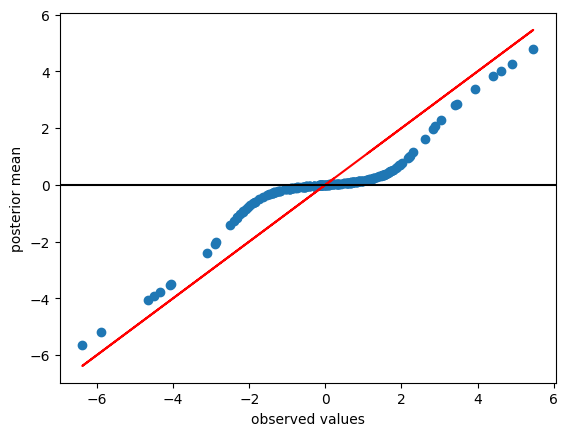

In [10]:
plt.scatter(betahat, res.post_mean  )
plt.xlabel("observed values")
plt.plot(betahat, betahat, color='red', label='x = y')
plt.axhline(y=0, color="black")
plt.ylabel("posterior mean")

In [11]:
print( np.sqrt(np.mean((np.concatenate((true_val1 , true_val0))     - betahat )**2)))
print(np.sqrt(np.mean((np.concatenate((true_val1 , true_val0))     - res.post_mean  )**2)))

0.9776881513088249
0.7618257328471782


In [12]:
true_val1=  np.random.normal(loc=0, scale=2, size=1000)
true_val0=  np.zeros( 1000)

observations_mu_1 =true_val1+np.random.normal(loc=0, scale=1, size=1000)
observations_mu_0 =true_val0+ np.random.normal(loc=0, scale=1, size=1000)

# Combine them into one array
betahat = np.hstack([observations_mu_1, observations_mu_0])
sebetahat=  np.repeat(1, betahat.shape[0])

In [13]:
res= ash(betahat, sebetahat)
print(res.pi) 

[3.87126947e-01 4.58875849e-02 1.74319174e-02 6.84122400e-03
 2.86919515e-03 1.38090697e-03 8.90285364e-04 1.07660357e-03
 4.17407717e-03 4.79295147e-02 3.49095725e-01 1.35146793e-01
 1.49224521e-04 5.53735242e-10 2.14537451e-10 1.09978505e-10
 6.31457664e-11]


in the large scale regime works well

Text(0, 0.5, 'posterior mean')

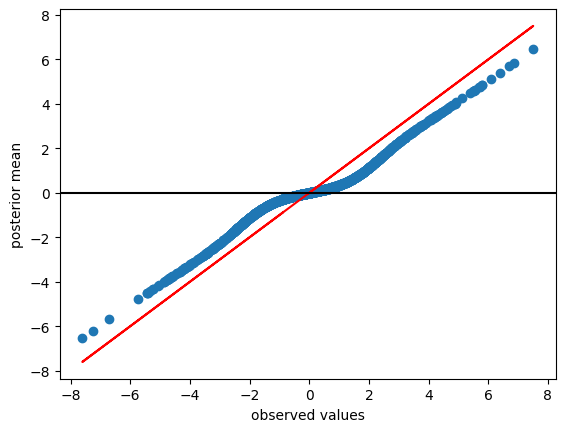

In [14]:
plt.scatter(betahat, res.post_mean  )
plt.xlabel("observed values") 
plt.plot(betahat, betahat, color='red', label='x = y')
plt.axhline(y=0, color="black")
plt.ylabel("posterior mean")

Text(0, 0.5, 'posterior mean')

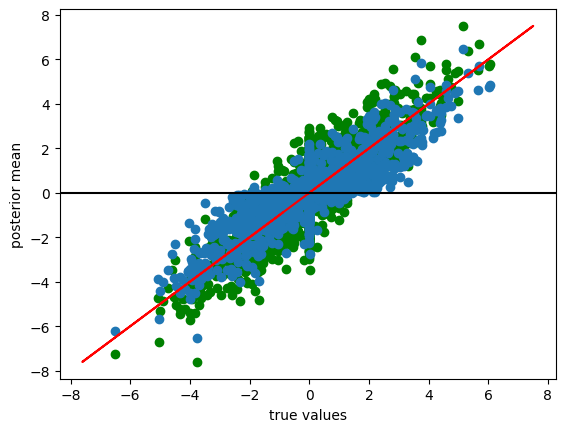

In [15]:
plt.scatter(np.concatenate((true_val1 , true_val0))    , betahat ,color="green" )
plt.scatter(np.concatenate((true_val1 , true_val0))    , res.post_mean  )
plt.xlabel("true values") 
plt.plot(betahat, betahat, color='red', label='x = y')
plt.axhline(y=0, color="black")
plt.ylabel("posterior mean")

In [16]:
print( np.sqrt(np.mean((np.concatenate((true_val1 , true_val0))     - betahat )**2)))
print(np.sqrt(np.mean((np.concatenate((true_val1 , true_val0))     - res.post_mean  )**2)))

1.0184039000177565
0.7600245517395992
